In [8]:
import sys
sys.path.append('../')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm, steadystate as steadystate_qc
from torchqc.correlation import correlation_fn_2op_1time, second_order_coherence_fn, fist_order_coherence_fn
from torchqc.operators import Operator
from torchqc.common_matrices import annihilation, creation
from torchqc.dynamics import lindblad_equation

from qutip import (coherent_dm, correlation_2op_2t, correlation_2op_1t, destroy, mesolve)
import qutip

* Compute first order correlation function

First compute it with qutip

In [9]:
N = 20
T = 10.0
steps = 1000
Dt = T / steps
taulist = np.linspace(0, T, steps + 1)
a = destroy(N)
H = 2 * np.pi * a.dag() * a

In [10]:
# collapse operator
Γ1 = 0.75
n_th = 2.00  # bath temperature in terms of excitation number
c_ops = [np.sqrt(Γ1 * (1 + n_th)) * a, np.sqrt(Γ1 * n_th) * a.dag()]

In [11]:
# start with a coherent state
rho0 = coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = mesolve(H, rho0, taulist, c_ops, [a.dag() * a]).expect[0]
n = np.array(n)

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = correlation_2op_2t(H, rho0, None, taulist, c_ops, a.dag(), a)
# extract taulist results
if len(G1.shape) == 2:
    G1 = G1[0]

g1 = G1 / np.sqrt(n[0] * n)

# first calculate the occupation number as a function of time
n = mesolve(H, rho0, taulist, c_ops, [a.dag() * a]).expect[0]
n = np.array(n)

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = correlation_2op_2t(H, rho0, None, taulist, c_ops, a.dag(), a)
# extract taulist results
if len(G1.shape) == 2:
    G1 = G1[0]

g1 = G1 / np.sqrt(n[0] * n)

* Compute first order correlation function with torchqc

In [12]:
N = 20
taulist2 = np.arange(0, T + Dt, Dt, dtype = np.float64)
taulist2 = np.linspace(0, T, steps+1)
a_dagger = creation(N)
a = annihilation(N)

H = 2 * np.pi * a_dagger * a

In [13]:
b = 2.0
coherent_state = QuantumState.coherent(N, b)
coherent_rho = get_density_matrix(coherent_state)

In [14]:
ham_tensor = H.matrix.expand(len(taulist2), -1, -1).type(torch.complex128)
hamiltonian = Operator(N, ham_tensor)
jump_ops = [a, a_dagger]
rates = [Γ1 * (1 + n_th), Γ1 * n_th]

initial_state = coherent_rho
time_tensor, states = lindblad_equation(initial_state, hamiltonian, taulist2, Dt, jump_ops, rates)
expect_values = expect_val_dm(states, a_dagger * a)

In [15]:
g1_torchqc = fist_order_coherence_fn(hamiltonian, coherent_rho, taulist2, Dt, a_dagger, a, jump_ops, rates)

Text(0.5, 0, '$\\tau$')

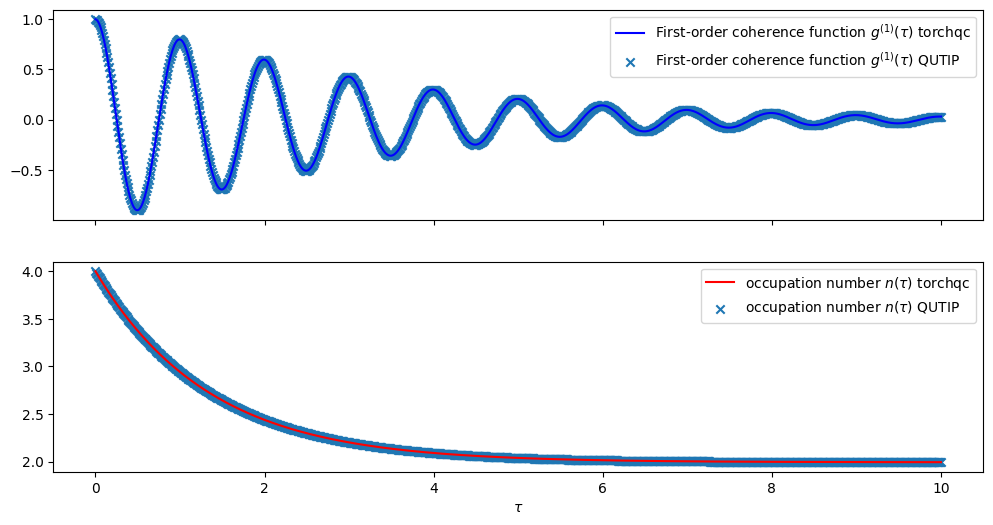

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

axes[0].plot(
    taulist2, np.real(g1_torchqc), "b",
    label=r"First-order coherence function $g^{(1)}(\tau)$ torchqc"
)

axes[0].scatter(
    taulist, np.real(g1), marker='x',
    label=r"First-order coherence function $g^{(1)}(\tau)$ QUTIP"
)

axes[1].plot(taulist2, expect_values, "r", label=r"occupation number $n(\tau)$ torchqc")
axes[1].scatter(taulist, np.real(n), marker='x', label=r"occupation number $n(\tau)$ QUTIP")
axes[0].legend()
axes[1].legend()
axes[1].set_xlabel(r"$\tau$")

* Steadystate correlation function

* Qutip calculation

In [17]:
T = 10.0
steps = 200
times = np.linspace(0, 10.0, 200)
Dt = T / steps
a = destroy(10)
x = a.dag() + a
H = a.dag() * a

corr1 = correlation_2op_1t(H, None, times, [np.sqrt(0.5) * a], x, x)
corr2 = correlation_2op_1t(H, None, times, [np.sqrt(1.0) * a], x, x)
corr3 = correlation_2op_1t(H, None, times, [np.sqrt(2.0) * a], x, x)

* torchqc calculation

In [18]:
a = annihilation(10)
a_dagger = creation(10)

x = a_dagger + a
H = a_dagger * a

# steadystate_qc(H, [a], [0.5])
corr1_torchqc = correlation_fn_2op_1time(H, None, times, Dt, x, x, [a], [0.5])
corr2_torchqc = correlation_fn_2op_1time(H, None, times, Dt, x, x, [a], [1.])
corr3_torchqc = correlation_fn_2op_1time(H, None, times, Dt, x, x, [a], [2.])

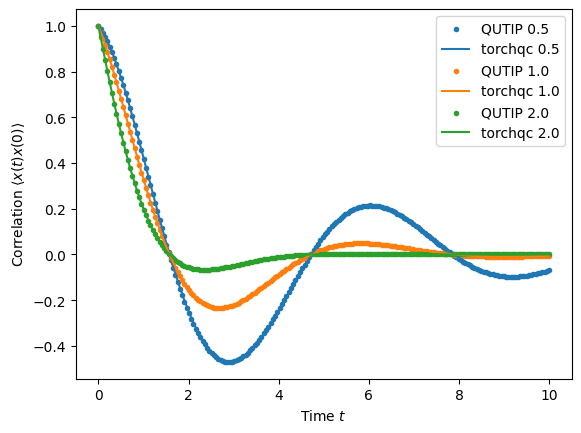

In [19]:
plt.figure()
plt.scatter(times, np.real(corr1), marker=".", label='QUTIP 0.5')
plt.plot(times, np.real(corr1_torchqc), label='torchqc 0.5')
plt.scatter(times, np.real(corr2), marker=".", label='QUTIP 1.0')
plt.plot(times, np.real(corr2_torchqc), label='torchqc 1.0')
plt.scatter(times, np.real(corr3), marker=".", label='QUTIP 2.0')
plt.plot(times, np.real(corr3_torchqc), label='torchqc 2.0')
plt.legend()
plt.xlabel(r'Time $t$')
plt.ylabel(r'Correlation $\left<x(t)x(0)\right>$')
plt.show()

* Second order coherence function

* QUTIP calculation

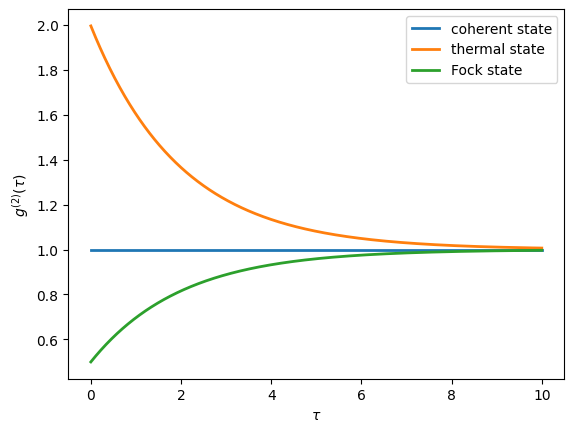

In [20]:
N = 25
T = 10.0
steps = 1000
Dt = T / steps
taus = np.linspace(0, T, steps)
a = qutip.destroy(N)
H = 2 * np.pi * a.dag() * a

kappa = 0.5
n_th = 2.0  # bath temperature in terms of excitation number
c_ops = [np.sqrt(kappa * (1 + n_th)) * a, np.sqrt(kappa * n_th) * a.dag()]

states = [
    {'state': qutip.coherent_dm(N, np.sqrt(2)), 'label': "coherent state"},
    {'state': qutip.thermal_dm(N, 2), 'label': "thermal state"},
    {'state': qutip.fock_dm(N, 2), 'label': "Fock state"},
]

fig, ax = plt.subplots(1, 1)

for state in states:
    rho0 = state['state']

    # first calculate the occupation number as a function of time
    n = qutip.mesolve(H, rho0, taus, c_ops, [a.dag() * a]).expect[0]

    # calculate the correlation function G2 and normalize with n(0)n(t) to
    # obtain g2
    G2 = qutip.correlation_3op_1t(H, rho0, taus, c_ops, a.dag(), a.dag()*a, a)
    g2 = np.array(G2) / (n[0] * np.array(n))

    ax.plot(taus, np.real(g2), label=state['label'], lw=2)

ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
plt.show()

* torchqc calculation

In [21]:
N = 25
a = annihilation(N)
a_dagger = creation(N)

H = 2 * np.pi * a_dagger * a

b = np.sqrt(2.0)
coherent_state = QuantumState.coherent(N, b)
coherent_rho = get_density_matrix(coherent_state)

fock_dm = get_density_matrix(QuantumState.basis(N)[2])

jump_ops = [a, a_dagger]
rates = [kappa * (1 + n_th), kappa * n_th]

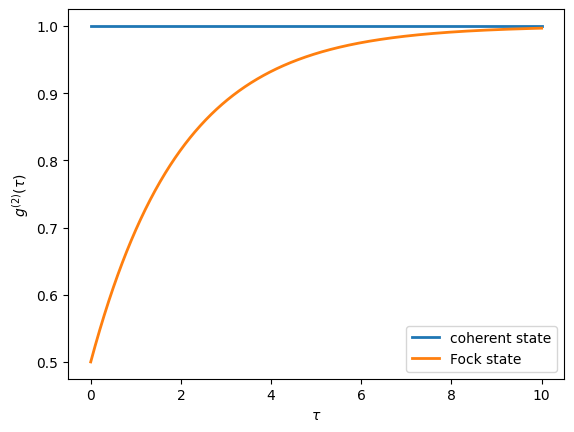

In [22]:
fig, ax = plt.subplots(1, 1)

states = [
    {'state': coherent_rho, 'label': "coherent state"},
    {'state': fock_dm, 'label': "Fock state"},
]

for dict in states:
    state = dict['state']
    label = dict['label']

    # compute the g2 correlation functuion
    g2_torchqc = second_order_coherence_fn(H, state, taus, Dt, a_dagger, jump_ops, rates)
    ax.plot(taus, np.real(g2_torchqc), lw=2, label=label)

ax.legend(loc=0)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$g^{(2)}(\tau)$')
plt.show()